Note: needs the `tossups.json` and `bonuses.json` file in the same directory as this file.

- It should contain all of the questions in the database dumped from mongodb.

In [1]:
import json
import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    s = ''.join(ch for ch in s if ch not in punctuation)
    s = s.replace('–', '-') # en dash
    s = s.replace('—', '-') # em dash
    return s


with open('stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

word_to_subcat = {}

with open('tossups.json') as tossups:
    for line in tqdm(tossups):
        data = json.loads(line)
        if 'subcategory' not in data:
            continue

        subcategory = data['subcategory']

        if subcategory not in SUBCATEGORIES:
            continue

        subcategory_index = SUBCATEGORIES.index(subcategory)

        if 'question' not in data or 'answer' not in data:
            continue

        tokens = removePunctuation(data['question'] + ' ' + data['answer']).lower().split()

        tokens = [token for token in tokens if token not in stop_words]
        for token in tokens:
            if token not in word_to_subcat:
                word_to_subcat[token] = [0 for _ in range(len(SUBCATEGORIES))]

            word_to_subcat[token][subcategory_index] += 1


with open('bonuses.json') as bonuses:
    for line in tqdm(bonuses):
        data = json.loads(line)
        if 'subcategory' not in data:
            continue

        subcategory = data['subcategory']

        if subcategory not in SUBCATEGORIES:
            continue

        subcategory_index = SUBCATEGORIES.index(subcategory)

        if 'leadin' not in data or 'parts' not in data or 'answers' not in data:
            continue

        tokens = removePunctuation(data['leadin'] + ' ' + ' '.join(data['parts']) + ' ' + ' '.join(data['answers'])).lower().split()

        tokens = [token for token in tokens if token not in stop_words]
        for token in tokens:
            if token not in word_to_subcat:
                word_to_subcat[token] = [0 for _ in range(len(SUBCATEGORIES))]

            word_to_subcat[token][subcategory_index] += 1

132191it [00:23, 5716.29it/s]
116919it [00:19, 5997.58it/s]


In [3]:
factors = {}

for word in word_to_subcat:
    factors[word] = (normalized_hhi(word_to_subcat[word]), sum(word_to_subcat[word]), SUBCATEGORIES[np.argmax(word_to_subcat[word])])

In [4]:
hhis = list(factors.values())
hhis = [hhi[0] for hhi in hhis]
hhis.sort()

In [5]:
n = len(hhis)

print(f'Number of words: {n}')
print(f'Average HHI: {sum(hhis) / len(hhis)}')
print(f'Median HHI: {hhis[n // 2]}')
print(f'{len([i for i in hhis if i == 1.0])} words with HHI = 1.0')

Number of words: 484865
Average HHI: 0.8140457964612478
Median HHI: 1.0
333439 words with HHI = 1.0


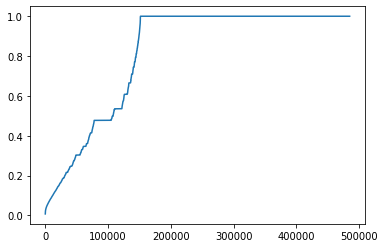

In [6]:
plt.plot(hhis)
plt.show()

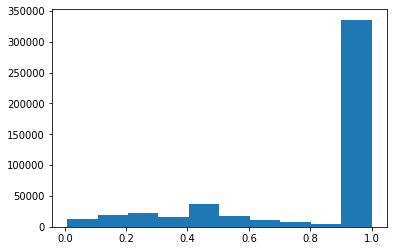

In [7]:
plt.hist(hhis)
plt.show()

In [ ]:
factor_values = [[word, factors[word][1], factors[word][2]] for word in factors if factors[word][0] > 0.9 and factors[word][1] >= 6 and factors[word][1] <= 10]
factor_values.sort(key=lambda x: x[1], reverse=False)
for x in factor_values:
    print(f"{x[0]:21} {x[1]:4} ({x[2]})")